<a href="https://colab.research.google.com/github/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/20-Tuesday/FittingDynamicalSystemsToNeuralData_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from tqdm import tqdm

**Exercise 1:** Exploring properties of linear dynamics

First, we will try to get some intuition about how linear dynamics and their properties shape the evolution of states over time. To do this, we will construct two-dimensional linear dynamics with different parameter settings, look at their eigenvalues and eigenvectors and simulate how the system evolves forward in time.

A linear dynamical system evolves in time according to the equation
$$ x_{t+1} = A x_{t} + \epsilon_t$$
Here, $x$ is the dynamical state variable, $A$ are the linear dynamics and $\epsilon \sim N(0,Q)$ is Gaussian noise. We will first explore this equation and how the evolution of $x$ depends on $A$ and $\epsilon$ in more details. 







1.   Implement a function that takes in an initial condition $x_0$, a dynamics matrix $A$, and the noise covariance $Q$, and simulates $x$ forward in time for T time-steps.


In [2]:
def predict_step_linearDynamics(A, x):
    return A.dot(x) 

def simulate_trial(f, x0, T, Q):
    # x_t+1 = f
    # x0 is the [k,] initial condition
    # T is the maximum number of timesteps we want to simulate
    # Q is the [k, k] noise covariance
    
    K = x0.shape[0]  
    x = np.zeros([K, T])
    x[:, 0] = x0[:]
    for i in range(T-1):
        x[:, i + 1] = f(x[:, i]) + np.random.multivariate_normal(np.zeros([K]), Q, 1)
    return x


2.   Explore how different choices for $A$ affect the state evolution. Some things to explore:

*   Write a function that generates a 2D rotation matrix
*   Write a function that generates a 2D symmetric matrix
*   Pick values for $x_0$, $Q$ and $A$ and simulate the dynamical system using the functions you wrote before
*   What happens when $A$ is symmetric, or a rotation matrix? What looks different about the state evolution? How does that relate to the eigenvalues and eigenvectors of $A$?
*   What happens when eigenvalues of $A$ are real or complex?
*   How does the size of the largest eigenvalue affect the evolution?
*   What changes when $Q$ is large or small?

You should try to visualize the state evolution of $x$ as a time series, and through a plot in 2D. Look at the functon `streamplot` as well to see if you can visualize the flow-field with the paths of $x_t$ overlaid on top. 



In [3]:
def rotation(r, theta):
    return r*np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def symmetric(r):
    a = np.random.randn(2,2)
    u = np.linalg.svd(a)[0]
    e = r* np.array([1., 0.5])
    return (u*e).dot(u.T)  

In [4]:
random.seed(1)
# make a linear system with a 2D rotation
x0 = np.array([-1, 1]) # initial condition
A = rotation(0.99, 0.5) # dynamics matrix
A_sym = symmetric(0.99) # dynamics matrix

Q = 0.01 * np.eye(2) # innovations noise

T = 100


tmax = 5
dt = 0.001

func_rot = lambda x: predict_step_linearDynamics(A, x)
func_sym = lambda x: predict_step_linearDynamics(A_sym, x)

xpath_Rotation = simulate_trial(func_rot, x0, T, Q) 
xpath_Symmetric = simulate_trial(func_sym, x0, T, Q) 


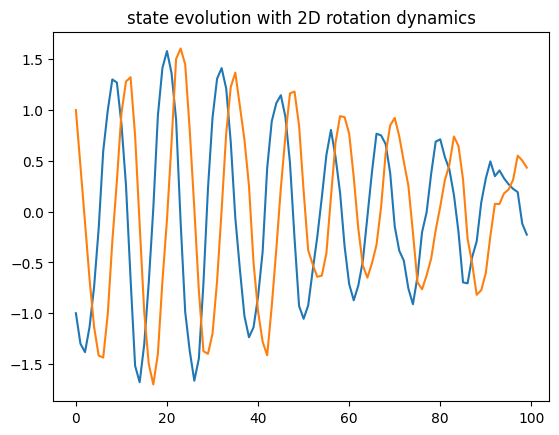

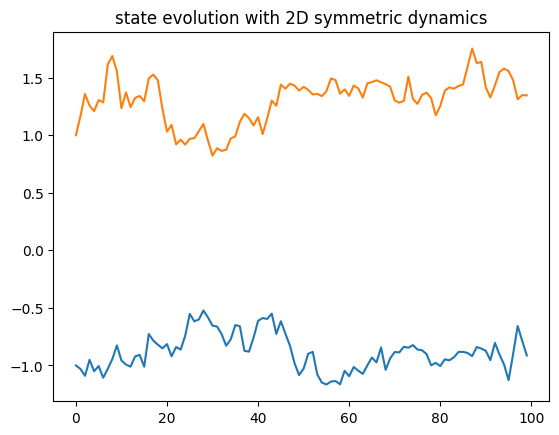

In [5]:
plt.plot(xpath_Rotation.T)
plt.title('state evolution with 2D rotation dynamics')
plt.show()

plt.plot(xpath_Symmetric.T)
plt.title('state evolution with 2D symmetric dynamics')
plt.show()


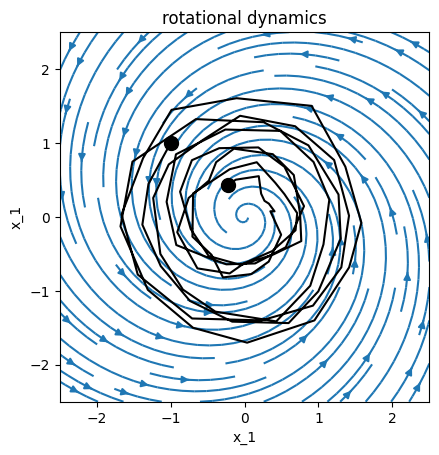

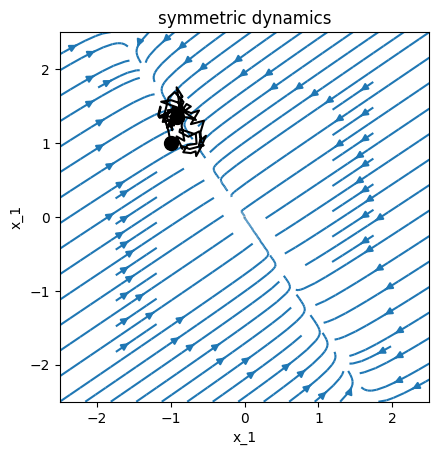

In [6]:
def plot_flowfield(func, ngrid=100,w=2.5):
    xv, yv = np.meshgrid(np.linspace(-w,w,ngrid), np.linspace(-w,w,ngrid))
    xygrid = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))
    xy_out = func(xygrid.T).T - xygrid # dt = x_t+1 - x_t
    U = xy_out[:,0].reshape(100,100)
    V = xy_out[:,1].reshape(100,100)
    speed = np.sqrt(U**2 + V**2)

    #drawing stream plot
    plt.streamplot(xv, yv, U, V)
    plt.axis('square')

    
plot_flowfield(func_rot, ngrid=100,w=2.5)
plt.title('rotational dynamics')
plt.plot(xpath_Rotation[0,0],xpath_Rotation[1,0],'k.',markersize=20)
plt.plot(xpath_Rotation[0,-1],xpath_Rotation[1,-1],'k.',markersize=20)
plt.plot(xpath_Rotation[0,:],xpath_Rotation[1,:],'k')
plt.xlabel('x_1')
plt.ylabel('x_1')

plt.show()

plot_flowfield(func_sym, ngrid=100,w=2.5)
plt.title('symmetric dynamics')
plt.plot(xpath_Symmetric[0,0],xpath_Symmetric[1,0],'k.',markersize=20)
plt.plot(xpath_Symmetric[0,-1],xpath_Symmetric[1,-1],'k.',markersize=20)
plt.plot(xpath_Symmetric[0,:],xpath_Symmetric[1,:],'k')
plt.xlabel('x_1')
plt.ylabel('x_1')
plt.show()

**Exercise 2:** Simulating a low dimensional linear dynamical system

Now that we have a better understanding of how linear dynamical systems work, we can connect this to a model for high-dimensional neural data. To do this, we will use the same set up as we did for models like Factor Analysis. Here, the low-dimensional dynamical system is embedded within a high-dimensional space as follows

$$ x_{t+1} = A x_{t} + \epsilon_t, \quad x \in \mathbb{R}^K$$

$$ y_{t} = C x_{t} + \eta_t, \quad y \in \mathbb{R}^N$$

$C$ is a $N \times K$ matrix, where $K \le N$, and $\eta \sim N(0,R)$ is noise. We'll assume $R$ is diagonal.

1.   Generate a time series for $x$ and $y$.
2.   Perform PCA on this data. Look at the dimensionality by plotting the singular values of the data covariance matrix. Visualise what the leading PC projections of the data look like.


In [7]:
random.seed(1)
# make a linear system with a 2D rotation
x0 = np.array([-1, 1]) # initial condition
A = rotation(0.99, 0.5) # dynamics matrix
Q = 0.1 * np.eye(2) # innovations noise
K = 2
N = 10
C = np.random.randn(N,K)
R = 0.5*np.eye(N) 
T = 100

def func(x):
    return predict_step_linearDynamics(A, x)


def simulate_LDS(func, x0, T, Q, C, R):
    xpath = simulate_trial(func, x0, T, Q)  
    ypath = C.dot(xpath) + np.random.multivariate_normal(np.zeros(N), R, T).T
    return ypath, xpath
    
ypath, xpath = simulate_LDS(func, x0, T, Q, C, R)

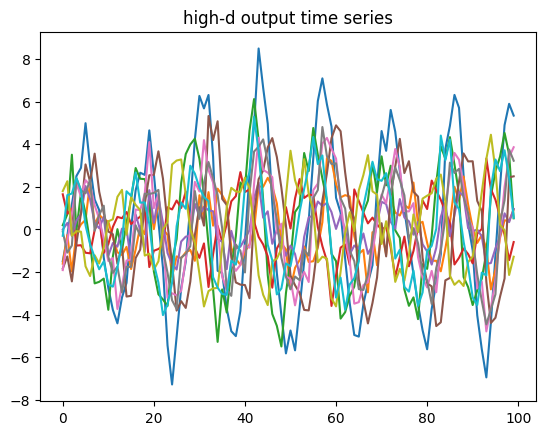

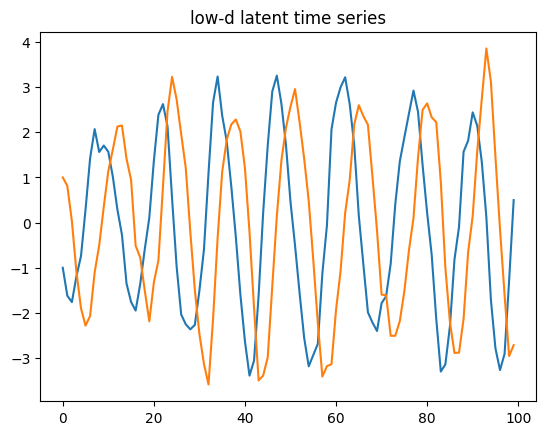

In [8]:
plt.plot(ypath.T)
plt.title('high-d output time series')
plt.show()

plt.plot(xpath.T)
plt.title('low-d latent time series')
plt.show()

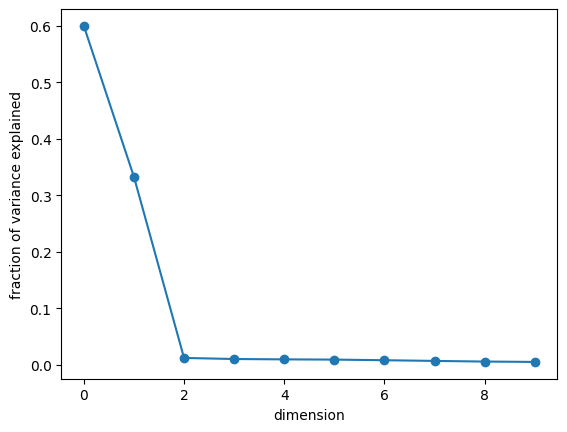

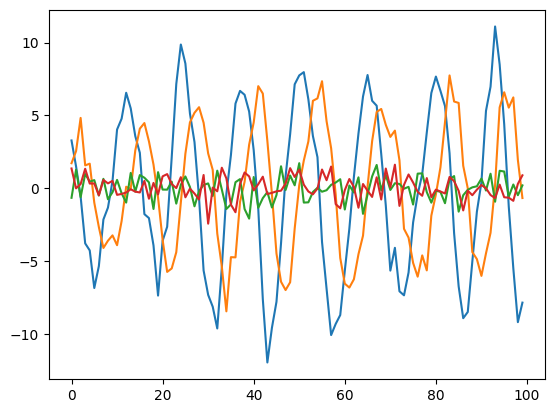

In [9]:
PCs = np.linalg.svd(ypath.dot(ypath.T))[0]
svds = np.linalg.svd(ypath.dot(ypath.T))[1]

# look at dimensionality
plt.plot(svds/sum(svds),'o-')
plt.xlabel('dimension')
plt.ylabel('fraction of variance explained')
plt.show()

# plot PC projections
nPCs=4 # number of PCs to plot
for i in range(nPCs):
    plt.plot(PCs[:,i].dot(ypath))
plt.show()

**Exercise 3:** Maximum likelihood learning via the EM algorithm

Now that we have noisy, high-dimensional data, we want to find a way to estimate the underlying dynamics and latent states from this data. In our example, we made the system up and we know the ground-truth, but in real world applications we need to trust that our algorithm will estimate the right parameters, given the assumptions we made about where the data came from. In this exercise, we will work to build an algorithm that allows us to input observed measurements ($y$) and extract estimates for $A$, $x$, etc. This algorithm is called the Expectation Maximization (EM) algorithm. We've already seen it for Factor Analysis and now we will extend it to our LDS model. EM is the foundation for a bunch of different Machine Learning algorithms.

In this exercise, we will step through some maths to understand what our algorithm is doing and derive and implement the inference and parameter update equations we need. You don't have to derive anything on your own, but try to work through each step and ask questions if you don't follow something. 



**EM for State Space Models**

Refer to the notes in the google drive folder.


**E-Step: Kalman smoothing**



The function below implements the parameter updates for this. For detailed derivations you can check out Byron's notes [ADD LINK]

In [10]:
def run_ssm_kalman(X, y_init, Q_init, A, Q, C, R, mode='smooth'):
    """
    Calculates kalman-smoother estimates of SSM state posterior.
    :param X:       data, [d, t_max] numpy array
    :param y_init:  initial latent state, [k,] numpy array
    :param Q_init:  initial variance, [k, k] numpy array
    :param A:       latent dynamics matrix, [k, k] numpy array
    :param Q:       innovariations covariance matrix, [k, k] numpy array
    :param C:       output loading matrix, [d, k] numpy array
    :param R:       output noise matrix, [d, d] numpy array
    :param mode:    'forw' or 'filt' for forward filtering, 'smooth' for also backward filtering
    :return:
    y_hat:      posterior mean estimates, [k, t_max] numpy array
    V_hat:      posterior variances on y_t, [t_max, k, k] numpy array
    V_joint:    posterior covariances between y_{t+1}, y_t, [t_max, k, k] numpy array
    likelihood: conditional log-likelihoods log(p(x_t|x_{1:t-1})), [t_max,] numpy array
    """
    d, k = C.shape
    t_max = X.shape[1]

    # dimension checks
    assert np.all(X.shape == (d, t_max)), "Shape of X must be (%d, %d), %s provided" % (d, t_max, X.shape)
    assert np.all(y_init.shape == (k,)), "Shape of y_init must be (%d,), %s provided" % (k, y_init.shape)
    assert np.all(Q_init.shape == (k, k)), "Shape of Q_init must be (%d, %d), %s provided" % (k, k, Q_init.shape)
    assert np.all(A.shape == (k, k)), "Shape of A must be (%d, %d), %s provided" % (k, k, A.shape)
    assert np.all(Q.shape == (k, k)), "Shape of Q must be (%d, %d), %s provided" % (k, k, Q.shape)
    assert np.all(C.shape == (d, k)), "Shape of C must be (%d, %d), %s provided" % (d, k, C.shape)
    assert np.all(R.shape == (d, d)), "Shape of R must be (%d, %d), %s provided" % (d, k, R.shape)

    y_filt = np.zeros((k, t_max))  # filtering estimate: \hat(y)_t^t
    V_filt = np.zeros((t_max, k, k))  # filtering variance: \hat(V)_t^t
    y_hat = np.zeros((k, t_max))  # smoothing estimate: \hat(y)_t^T
    V_hat = np.zeros((t_max, k, k))  # smoothing variance: \hat(V)_t^T
    K = np.zeros((t_max, k, X.shape[0]))  # Kalman gain
    J = np.zeros((t_max, k, k))  # smoothing gain
    likelihood = np.zeros(t_max)  # conditional log-likelihood: p(x_t|x_{1:t-1})

    I_k = np.eye(k)

    # forward pass

    V_pred = Q_init
    y_pred = y_init

    for t in range(t_max):
        x_pred_err = X[:, t] - C.dot(y_pred)
        V_x_pred = C @V_pred@C.T + R
        V_x_pred_inv = np.linalg.inv(V_x_pred)
        likelihood[t] = -0.5 * (np.linalg.slogdet(2 * np.pi * (V_x_pred))[1] +
                                x_pred_err.T.dot(np.linalg.solve(V_x_pred,x_pred_err)))

        K[t] = np.linalg.solve(V_x_pred.T, C@V_pred.T).T
        
        
        y_filt[:, t] = y_pred + K[t].dot(x_pred_err)
        V_filt[t] = V_pred - K[t]@C@V_pred

        # symmetrise the variance to avoid numerical drift
        V_filt[t] = (V_filt[t] + V_filt[t].T) / 2.0

        y_pred = A.dot(y_filt[:, t])
        V_pred = A @V_filt[t]@A.T + Q

    # backward pass

    if mode == 'filt' or mode == 'forw':
        # skip if filtering/forward pass only
        y_hat = y_filt
        V_hat = V_filt
        V_joint = None
    else:
        V_joint = np.zeros_like(V_filt)
        y_hat[:, -1] = y_filt[:, -1]
        V_hat[-1] = V_filt[-1]

        for t in range(t_max - 2, -1, -1):            
            J[t] = np.linalg.solve(A@V_filt[t]@A.T + Q, A@V_filt[t].T).T
            
            y_hat[:, t] = y_filt[:, t] + J[t].dot((y_hat[:, t + 1] - A.dot(y_filt[:, t])))
            V_hat[t] = V_filt[t] + J[t]@(V_hat[t + 1] - A@V_filt[t]@A.T - Q)@J[t].T

        V_joint[-2] = (I_k - K[-1]@C)@A@V_filt[-2]

        for t in range(t_max - 3, -1, -1):
            V_joint[t] = V_filt[t + 1]@J[t].T + J[t + 1]@(V_joint[t + 1] - A@V_filt[t + 1])@J[t].T

    return y_hat, V_hat, V_joint, likelihood

**M-Step: Parameter updates**


These are also derived in the notes. Make sure you can follow and reproduce each step!

Now that we have all updates for the M-Step, we can put everything together into an implementation of the EM algorithm.

In [11]:
def run_EM(X, y0, Q0, A, Q, C, R, maxiter=100, tol=1e-4):
    # X is the d x T data matrix
    # y0 is the initial condition for the latent state
    # Q0 is the initial Covariance of the first time step
    # A,Q,C,R are starting values for our parameters
    # maxiter is the maximum number of iterations to perform
    # tol is the convergence tolerance
    
    D, K = C.shape
    T = X.shape[1]
    loglike = []
    
    for i in tqdm(range(maxiter)):

        # perform the E step
        Y, V, Vj, likelihood = run_ssm_kalman(X, y0, Q0, A, Q, C, R, mode='smooth')
        loglike.append(sum(likelihood))

        # make sure that likelihood increases and check convergence
        if i > 0:
            diff = loglike[i] - loglike[i-1]
            if diff < 0:
                warnings.warn("decrease in log-likelihood detected")
        else:
            diff = []
        
        if i > 0 and abs(diff) < tol:
            print('EM has converged')
            break
                  
        # perform the M step
        cc2 = sum(V) + Y@Y.T
        cc1 = X@Y.T
        rr1 = X@X.T
        aa1 = sum(V) + Y[:,:-1]@Y[:,:-1].T
        aa2 = sum(Vj) + Y[:,1:]@Y[:,:-1].T
        qq1 = sum(V[1:]) + Y[:,1:]@Y[:,1:].T

        # C update
        C = np.linalg.solve(cc2.T,cc1.T).T

        # A update
        A = np.linalg.solve(aa1.T,aa2.T).T
        
        # R update     
        R = np.diag(np.diag((rr1 - C@cc1.T)/T)) # diagonal matrix is more stable for real data application
#         R = ((rr1 - C@cc1.T)/T) # full update but unstable with limited real data
        
        # Q update
        Q = (qq1 - aa2@A.T)/(T-1)
                    
        # symmetrize covariances for numerical stability
        Q = 0.5*(Q + Q.T)
        R = 0.5*(R + R.T)

        # update initial conditions
        y0 = Y[:,0]
        Q0 = V[0] - y0.dot(y0.T) 
                
    return A, Q, C, R, y0, Q0, Y, V, Vj, loglike

**Exercise 4:** Applying EM to simulated data

Now that we have our EM algorithm ready to go, we can put things together into a loop and see if we can get our initial parameters back. Below is a framework for how to structure this as a function. Fill in the gaps with the functions we've already written above and run it on our 2D synthetic data example.

In [12]:
x0 = np.zeros(2)
Q0 = np.eye(2)
Ainit = 0.5*np.eye(2)

Ahat, Qhat, Chat, Rhat, x0hat, Q0hat, X, V, Vj, loglike = run_EM(ypath, x0, Q0, Ainit, Q, C, R, maxiter=1000)

100%|██████████| 1000/1000 [00:33<00:00, 29.71it/s]


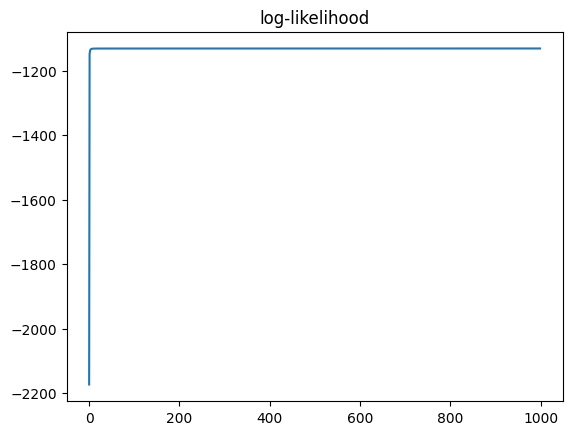

In [13]:
plt.plot(loglike)
plt.title('log-likelihood')
plt.show()

**Exercise 5:** Diagnostics and assesing goodness of fit

Now that we've ran our algorithm, how can we tell if we learned the right thing? Since we made up the data until now, we know what our true system looks like. We can first check that the output of our algorithm aligns with the ground truth.


1.   Plot the inferred latent variables along with the true underlying 2D system and see if they match.

2.   Does our estimate $\hat{A}$ have the same entries as our true generative $A$? Why would you expect this, or why not? Do the eigenvalues and eigenvectors match? Think about why looking at eigenvalues and eigenvectors is a better measure for assessing whether the parameters match


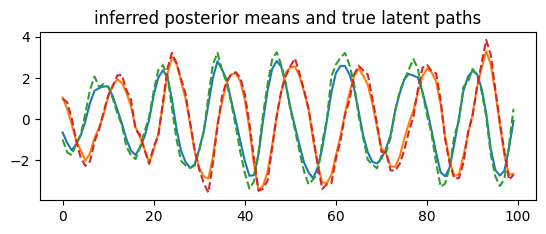

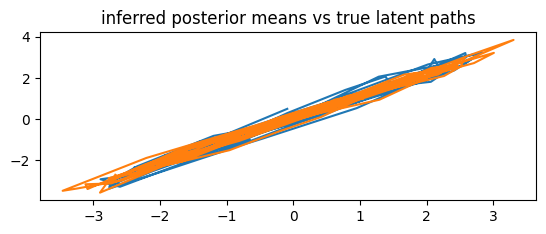

In [14]:
plt.subplot(2,1,1)
plt.plot(X.T)
plt.plot(xpath.T,'--')
plt.title('inferred posterior means and true latent paths')
plt.show()

plt.subplot(2,1,2)
plt.plot(X.T, xpath.T)
plt.title('inferred posterior means vs true latent paths')
plt.show()

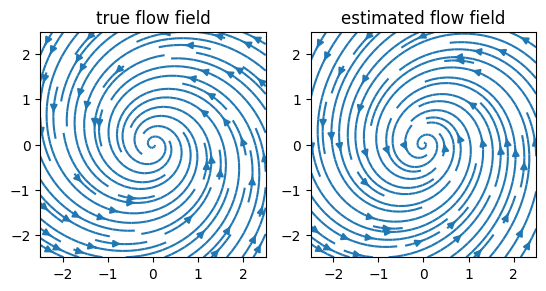

In [15]:
plt.subplot(1,2,1)
plot_flowfield(lambda x:predict_step_linearDynamics(A, x))
plt.title('true flow field')

plt.subplot(1,2,2)
plot_flowfield(lambda x:predict_step_linearDynamics(Ahat, x))
plt.title('estimated flow field')

plt.show()

In [16]:
print('true dynamics:')
print(A)

print('estimated dynamics:')
print(Ahat)


true dynamics:
[[ 0.86880674 -0.47463128]
 [ 0.47463128  0.86880674]]
estimated dynamics:
[[ 0.94489101 -0.43357086]
 [ 0.48080606  0.82424155]]


In [17]:
print('true dynamics eigen decomp:')
print(np.linalg.eig(A))

print('estimated dynamics eigen decom:')
print(np.linalg.eig(Ahat))

true dynamics eigen decomp:
(array([0.86880674+0.47463128j, 0.86880674-0.47463128j]), array([[0.70710678+0.j        , 0.70710678-0.j        ],
       [0.        -0.70710678j, 0.        +0.70710678j]]))
estimated dynamics eigen decom:
(array([0.88456628+0.45257532j, 0.88456628-0.45257532j]), array([[0.09098039+0.68256384j, 0.09098039-0.68256384j],
       [0.72514079+0.j        , 0.72514079-0.j        ]]))



In real-world applications, we don't have access to the true underlying parameters. We want to look at data to estimate them and learn something new! So how can we assess whether our model is a good model? This is a tough question and still an active topic of debate and research.


3.   Think about what makes a model a "good" model. Can you come up with a list of features you'd like a good model to have? 

A common measure is to assess a model by asking: how well does it fit the data? Another way to ask this question is: How much variability in our observed data can be explained by our model? This is sometimes also called "the fraction of variance explained". 

4.   Below we have code to compute the fraction of variance that is explained by our model in the simulated data. Evaluate this for our current model fit and make a note of the value, then repeat the data generation and fitting procedure while increasing the level of noise in the latent states and in the data. What do you see now?

5.   Can you think of a way to report variance explained that would be less sensitive to noise variance?






In [18]:
def varianceExplained(Y, Yhat):
    Yc = Y - np.mean(Y,axis=1)[:,None]
    diff = Y - Yhat
    RSS = np.trace(diff.dot(diff.T))
    TSS = np.trace(Yc.dot(Yc.T))
    Rsq = 1 - RSS/TSS
    return Rsq

yexpl = Chat.dot(X)
varianceExplained(ypath,yexpl)

0.9232171748232091

How does this number change when we use a function to predict forward in time using the learned model rather than the inferred latent variables?

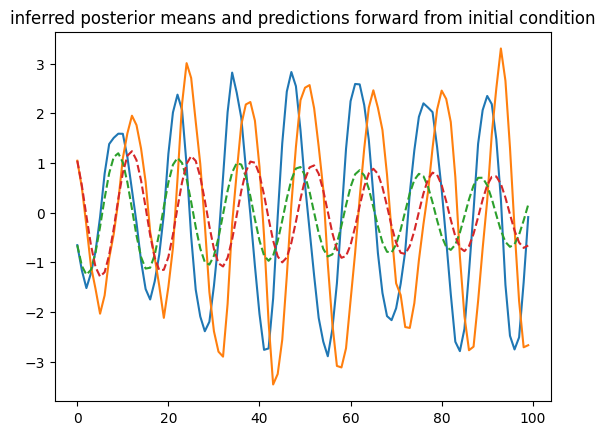

In [19]:
def predict_path(f, x0, T):
    # x_t+1 = f
    # x0 is the [k,] initial condition
    # T is the maximum number of timesteps we want to simulate
    
    K = x0.shape[0]  
    x = np.zeros([K, T])
    x[:, 0] = x0[:]
    for i in range(T-1):
        x[:, i + 1] = f(x[:, i])
    return x

func_fit = lambda x: predict_step_linearDynamics(Ahat, x)

xpred = predict_path(func_fit, x0hat, T)

plt.plot(X.T)
plt.plot(xpred.T,'--')
plt.title('inferred posterior means and predictions forward from initial condition')
plt.show()


In [20]:
yexpl_pred = Chat.dot(xpred)
varianceExplained(ypath,yexpl_pred)

0.4613974665399695

**Exercise 6:** Application to neural data

We now have a full algorithm to take high-dimensional data and infer a low-dimensional time series of latent states, and the dynamical system that explains their evolution in time from data. So far we have only worked with toy data, but we are now ready to put our algorithm to the test and see if it can extract interesting structure from neural data. 

We will fit a dynamical system to trial-averaged data from motor cortex during movement execution. 





In [23]:
import scipy.io

from google.colab import drive
drive.mount('https://drive.google.com/drive/folders/1WMP6t7IS7zw4V7JG4bucHuWPLtgY-uqv')
mat = scipy.io.loadmat('neuralData_ReachingTask.mat')    

MessageError: ignored

In [ ]:
MO = int(mat['MO']) # movement onset
GC = int(mat['GC']) # go cue
Xneur = mat['X'] # C x T x N data matrix for C = 4 reach targets 

# select a single target direction to fit
ctarg = 0
ytarg = (Xneur[ctarg,:,:].T - np.mean(Xneur[ctarg,:,:].T,axis=1)[:, None])/np.std(Xneur[ctarg,:,:])

Now that we have loaded the data, we can get a sense of it's dimensionality and the kind of acitivity patterns motor cortex expresses during reaching by applying our old friend PCA to the data.

1. Compute the data covariance matrix and plot its singular values.
2. Plot the projections of the neural data along the leading principal components.

In [ ]:
PCs = np.linalg.svd(ytarg.dot(ytarg.T))[0]
svds = np.linalg.svd(ytarg.dot(ytarg.T))[1]

# look at dimensionality
plt.plot(svds[:20]/sum(svds),'o-')
plt.plot(np.cumsum(svds[:20]/sum(svds)),'o-')
plt.plot(0.9*np.ones(20,),'k')

plt.xlabel('dimension')
plt.ylabel('fraction of variance explained')
plt.show()

# plot PC projections
nPCs=4 # number of PCs to plot
for i in range(nPCs):
    plt.plot(PCs[:,i].dot(ytarg))
plt.show()


We also have our fancy EM algorithm, so we can do more than using PCA! Let's try to fit a dynamical system to our motor cortex data.
1. Initialize model paramters with random values
2. Run the EM algorithm for your choice of dimensionality K

In [ ]:
k =3
d = ytarg.shape[0]

x0 = np.random.randn(k)
Q0 = np.eye(k)

# initialize parameters
Cinit = np.random.randn(d,k)
Qinit = 0.1*np.eye(k)
Rinit = 0.5*np.eye(d)
Ainit = 0.9*np.eye(k)

Ahat, Qhat, Chat, Rhat, y0hat, Q0hat, X, V, Vj, loglike = run_EM(ytarg, x0, Q0, Ainit, Qinit, Cinit, Rinit, maxiter=50)


3. Visualize the inferred posterior means. Do they look similar to the PC projections from before?

In [ ]:
plt.plot(X.T)
plt.title('inferred posterior means')
plt.show()

4. Inspect the eigenvalues of the learned dynamics matrix. What do you notice about them? Is this what you expected based on our earlier exploration of properties of linear dynamics?

In [ ]:
evals = np.linalg.eig(Ahat)[0]
plt.subplot(1,2,1)
plt.plot(np.real(evals),np.imag(evals),'.')

By now, we have a pretty good understanding of linear dynamics and we managed to implement a whole machine learning algorithm and applied it to neural data. But we also only looked at a single target direction. 

1. Look at the neural data for all targets using PCA. Do you think a single linear system could model this? Why? Why not?
2. Try to run the fitted model forward from an initial condition for a single or multiple targets. Do the model predictions look good? 

A limitation of linear systems is that they only have a single fixed point. This can be pretty restrictive, especially when movements to different targets produce pretty different-looking neural activity that might move to different points in the high-dimensional neural space. A simple but powerful extension to this simple linear model is to add an offset parameter that is condition specific and potentially time-varying:

$$ x^c_{t+1} = A x^c_{t} + b^c_t + \epsilon_t $$

2. What does this kind of extension change about our model? What flexibility do we now have that we didn't have before? Do you think this will alleviate some of the problems we saw in our predictions forward from an initial condition?

If you are still hungry for more we can try to implement this kind of model extension as a bonus exercise! If you are saturated it's also okay to lean back and relax and dream about all the ways you could apply what you've learned today in your course project.

**BONUS EXERCISE: Adding an offset to our model**

Let's try to get EM running for this model. We'll need to modify the E-Step to incorporate the extra paramter $b^c_t$, and derive a new update for $b^c$ for the M-step. 

It turns out that a piecewise constant $b^c_t$ is a good choice for our motor cortex data. This means that both the preparatory period (the monkey sees a target and plans his movement to it but doesn't move yet) and the movement period (the monkey executes his arm reach) can be described by thge same linear dynamics, but the fixed point of the linear system moves around across task epochs (preparator vs. movement) and conditions (target direction). 


In [ ]:
TS = 64 # time when b^c should switch from prep to move

1. Adapt the EM code to work with a `N x T x C ` dimensional data tensor (instead of N x T before)
2. Adapt the Kalman Smoother to include a `K x T x C` input time series `U`
3. Derive and implement the M-Step update for $b^c_{prep}$ and $b^c_{move}$
4. Write a function that takes $b^c_{prep}$ and $b^c_{move}$ and converts them into the approriate time-series of inputs `U`
5. Put everyting together into an EM algorithm as before
6. Try to run it and plot the log-likelihood. Does it increase at each iteration? If not you have bug somewhere!
7. How well does the model fit the data? Can you generate a prediction 



